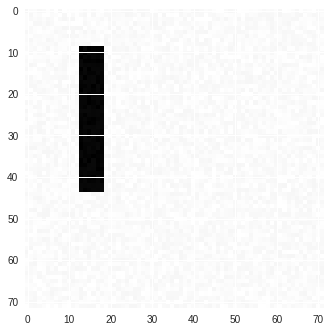

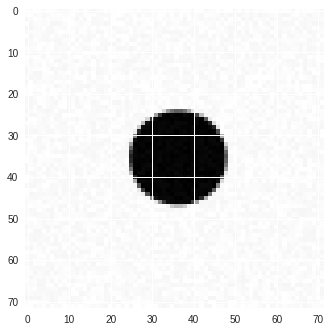

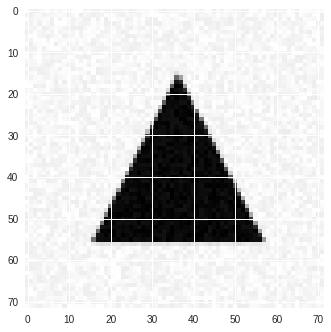

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

plt.figure(0)
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.figure(1)
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.figure(2)
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
#         if i % 10 == 0:
#             print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
#         if i % 10 == 0:
#             print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


In [0]:
!pip install -q keras


In [0]:
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.layers import Dense, Input, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential

## 3 Simple Classification

We implement a simple neural network with only 3 nodes

In [0]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
# 0 rectangle, 1 circle, 2 triangle
Y_train = np_utils.to_categorical(Y_train, 3)

Creating data:


In [0]:
model = Sequential()
model.add(Dense(3, input_shape=(X_train.shape[1],)))
model.add(Activation('softmax'))

In [0]:
nb_epochs = 50
init_lr = 0.001
sgd = optimizers.SGD(lr=init_lr, decay=init_lr/nb_epochs, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=init_lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=init_lr/nb_epochs, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, epochs=nb_epochs, verbose=1)

Epoch 1/50
300/300 [==============================] - 0s 570us/step - loss: 1.3620 - acc: 0.3700
Epoch 2/50
300/300 [==============================] - 0s 157us/step - loss: 0.6623 - acc: 0.7233
Epoch 3/50
300/300 [==============================] - 0s 144us/step - loss: 0.5351 - acc: 0.7700
Epoch 4/50
300/300 [==============================] - 0s 148us/step - loss: 0.3780 - acc: 0.8867
Epoch 5/50
300/300 [==============================] - 0s 150us/step - loss: 0.3260 - acc: 0.9067
Epoch 6/50
300/300 [==============================] - 0s 153us/step - loss: 0.2907 - acc: 0.9200
Epoch 7/50
300/300 [==============================] - 0s 152us/step - loss: 0.2592 - acc: 0.9500
Epoch 8/50
300/300 [==============================] - 0s 145us/step - loss: 0.2265 - acc: 0.9533
Epoch 9/50
300/300 [==============================] - 0s 147us/step - loss: 0.2058 - acc: 0.9667
Epoch 10/50
300/300 [==============================] - 0s 148us/step - loss: 0.1887 - acc: 0.9667
Epoch 11/50
300/300 [========

array([[0., 1., 0.]], dtype=float32)

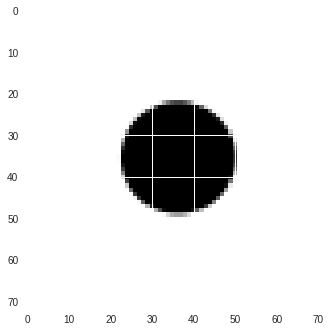

In [0]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
model.predict(X_test)

## 4 Visualization of the Solution

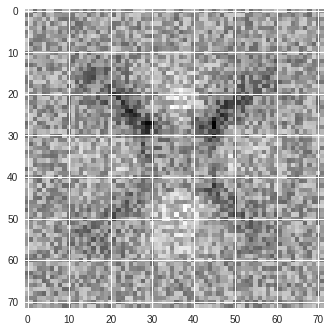

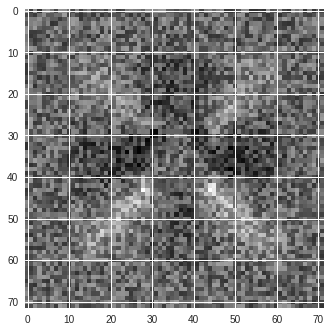

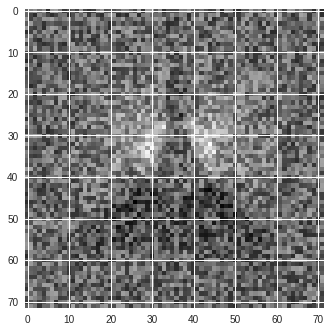

In [0]:
weights = model.get_weights()
for i in range(3):
  im=weights[0][:,i]
  plt.figure(i)
  plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## 5 A More Difficult Classification Problem

Import the data

In [0]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
# 0 rectangle, 1 disk, 2 triangle
Y_train = np_utils.to_categorical(Y_train, 3)
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

Creating data:
Creating data:


Define the model

In [0]:
model = Sequential()

model.add(Conv2D(16, (5, 5), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
model.add(Flatten())
print(model.output_shape)

model.add(Dense(128, activation='relu'))
print(model.output_shape)

model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
print(model.output_shape)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 128)
(None, 3)


Train the model

In [0]:
nb_epochs = 150
init_lr = 0.01
sgd = optimizers.SGD(lr=init_lr, decay=init_lr/nb_epochs, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=init_lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=init_lr/nb_epochs, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, epochs=nb_epochs, verbose=1)

Epoch 1/150
300/300 [==============================] - 1s 4ms/step - loss: 3.7798 - acc: 0.3867
Epoch 2/150
300/300 [==============================] - 0s 461us/step - loss: 0.8264 - acc: 0.6133
Epoch 3/150
300/300 [==============================] - 0s 452us/step - loss: 0.6191 - acc: 0.7767
Epoch 4/150
300/300 [==============================] - 0s 475us/step - loss: 0.4298 - acc: 0.8467
Epoch 5/150
300/300 [==============================] - 0s 489us/step - loss: 0.2831 - acc: 0.8867
Epoch 6/150
300/300 [==============================] - 0s 475us/step - loss: 0.2314 - acc: 0.8967
Epoch 7/150
300/300 [==============================] - 0s 479us/step - loss: 0.1379 - acc: 0.9467
Epoch 8/150
300/300 [==============================] - 0s 469us/step - loss: 0.0875 - acc: 0.9700
Epoch 9/150
300/300 [==============================] - 0s 481us/step - loss: 0.7886 - acc: 0.8333
Epoch 10/150
300/300 [==============================] - 0s 493us/step - loss: 0.2178 - acc: 0.8967
Epoch 11/150
300/300 

Test the model

In [0]:
print(model.metrics_names)
model.evaluate(X_test, Y_test)

['loss', 'acc']
300/300 [==============================] - 0s 1ms/step


[2.718612074057261, 0.6933333325386047]

## 6 A Regression Problem

FIrst we need to normalize the vertices by storing them in clockwise order (starting from the one on top)

In [0]:
def order_vertex(Y):
    y = Y[:].reshape(3,2)
    y = y[y[:,1].argsort()]
    #a
    #bc
    a = y[-1]
    tmp = y[:-1]
    tmp= tmp[tmp[:,0].argsort()]
    b = tmp[0]
    c = tmp[1]
    if (c[0]>a[0] and b[0]>a[0]):
      if (c[1]<b[1] and np.cross(a-b,a-c)<0):
        b,c = c,b 
    if (c[0]<a[0] and b[0]<a[0]):
      if (c[1]>b[1] and np.cross(a-b,a-c)<0):
        b,c = c,b 
    return np.concatenate((a,c,b),axis=0)

Import and normalize the data

In [242]:
[X_train, Y_train] = generate_dataset_regression(5000, 20)
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_train = np.asarray([order_vertex(y) for y in Y_train])

[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test = np.asarray([order_vertex(y) for y in Y_test])

Creating data:
Creating data:


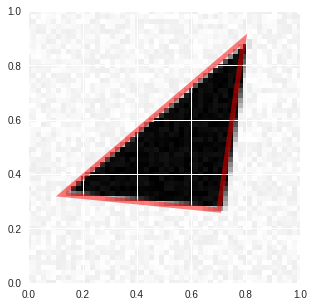

In [243]:
visualize_prediction(X_train[0], Y_train[0])

Define the model

In [0]:
model = Sequential()
model.add(Conv2D(32, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), kernel_size=(5,5)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (5,5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='linear'))

Train the model

In [245]:
nb_epochs = 300
init_lr = 0.01
sgd = optimizers.SGD(lr=init_lr, decay=init_lr/nb_epochs, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=init_lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=init_lr/nb_epochs, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=sgd)
model.fit(X_train, Y_train, batch_size=32, epochs=nb_epochs, validation_split=0.1, verbose=1)

Train on 4500 samples, validate on 500 samples
Epoch 1/300
4500/4500 [==============================] - 6s 1ms/step - loss: 0.0646 - val_loss: 0.0491
Epoch 2/300
4500/4500 [==============================] - 2s 487us/step - loss: 0.0404 - val_loss: 0.0380
Epoch 3/300
4500/4500 [==============================] - 2s 487us/step - loss: 0.0332 - val_loss: 0.0323
Epoch 4/300
4500/4500 [==============================] - 2s 487us/step - loss: 0.0285 - val_loss: 0.0290
Epoch 5/300
4500/4500 [==============================] - 2s 513us/step - loss: 0.0256 - val_loss: 0.0267
Epoch 6/300
4500/4500 [==============================] - 2s 507us/step - loss: 0.0234 - val_loss: 0.0250
Epoch 7/300
4500/4500 [==============================] - 2s 507us/step - loss: 0.0220 - val_loss: 0.0234
Epoch 8/300
4500/4500 [==============================] - 2s 506us/step - loss: 0.0205 - val_loss: 0.0227
Epoch 9/300
4500/4500 [==============================] - 2s 500us/step - loss: 0.0194 - val_loss: 0.0235
Epoch 10/3

Results :

In [250]:
Y = model.predict(X_test)

model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 280us/step


0.007268470308432976

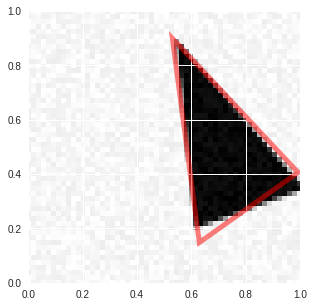

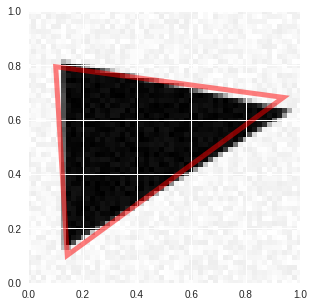

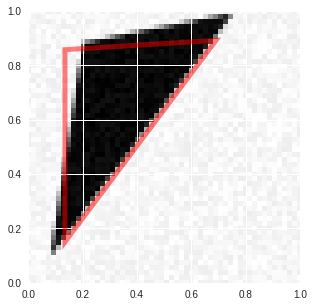

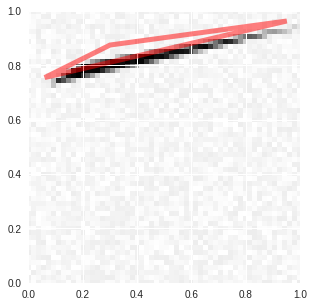

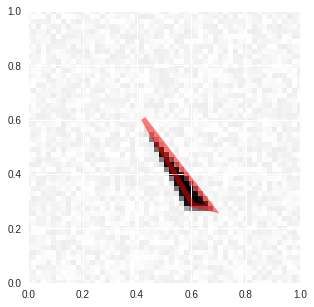

In [258]:
n = 41
visualize_prediction(X_test[n], Y[n])
n +=1
visualize_prediction(X_test[n], Y[n])
n +=1
visualize_prediction(X_test[n], Y[n])
n +=1
visualize_prediction(X_test[n], Y[n])
n +=1
visualize_prediction(X_test[n], Y[n])

## 7 Image Denoising

Import the data

In [0]:
from random import randint

def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noise = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        noise = randint(50,500)
        if category == 0:
            X[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(0, free_location)
        else:
            [X[i], V] = generate_a_triangle(0, free_location)
        X_noise[i] = X[i] + noise * np.random.random(X[i].size)
        X_noise[i] = (X_noise[i] + noise) / (255 + 2 * noise)
    X = X/255
    return [X, X_noise]

def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, X_test_noisy] = generate_dataset_denoising(300, True)
    return [X_test, X_test_noisy]

In [202]:
[X_train, X_train_noisy] = generate_dataset_denoising(10000, True)
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_train_noisy = X_train_noisy.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

[X_test, X_test_noisy] = generate_test_set_denoising()
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test_noisy = X_test_noisy.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

Creating data:
Creating data:


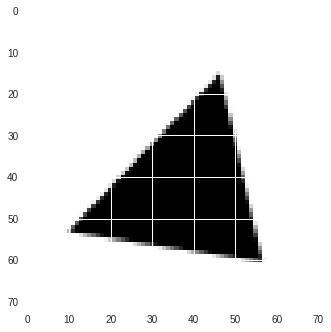

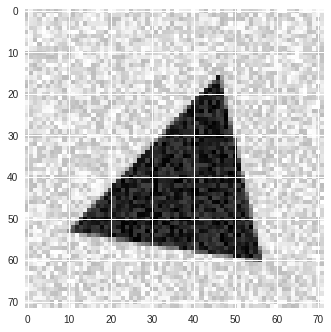

In [204]:
n = 9000
plt.figure(0)
plt.imshow(X_train[n].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.figure(1)
plt.imshow(X_train_noisy[n].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

Define the model : we use an autoencoder-type (hourglass) architecture. The output of the model is the desired denoised image.

In [215]:
model = Sequential()

model.add(Conv2D(32, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), kernel_size=(3,3)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
print(model.output_shape)

model.add(Conv2D(32, (3,3), activation="relu", padding='same'))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
print(model.output_shape)

model.add(Conv2D(32, (3,3), activation="relu", padding='same'))
print(model.output_shape)

model.add(UpSampling2D((2,2)))
print(model.output_shape)

model.add(Conv2D(32, (3,3), activation="relu",padding='same'))
print(model.output_shape)

model.add(UpSampling2D((2,2)))
print(model.output_shape)

model.add(Conv2D(1, (3,3), activation="sigmoid",padding='same'))
print(model.output_shape)


(None, 72, 72, 32)
(None, 36, 36, 32)
(None, 36, 36, 32)
(None, 18, 18, 32)
(None, 18, 18, 32)
(None, 36, 36, 32)
(None, 36, 36, 32)
(None, 72, 72, 32)
(None, 72, 72, 1)


Train the model

In [216]:
nb_epochs = 100
init_lr = 0.01
sgd = optimizers.SGD(lr=init_lr, decay=init_lr/nb_epochs, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=init_lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=init_lr/nb_epochs, amsgrad=False)

model.compile(optimizer=sgd, loss='binary_crossentropy')
model.fit(X_train_noisy, X_train, batch_size=128, epochs=nb_epochs, validation_split=0.1, verbose=1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 9s 983us/step - loss: 0.3093 - val_loss: 0.2439
Epoch 2/100
9000/9000 [==============================] - 5s 587us/step - loss: 0.1790 - val_loss: 0.0975
Epoch 3/100
9000/9000 [==============================] - 5s 594us/step - loss: 0.2105 - val_loss: 0.0859
Epoch 4/100
9000/9000 [==============================] - 5s 588us/step - loss: 0.0382 - val_loss: 0.0231
Epoch 5/100
9000/9000 [==============================] - 5s 589us/step - loss: 0.0214 - val_loss: 0.0206
Epoch 6/100
9000/9000 [==============================] - 5s 589us/step - loss: 0.0202 - val_loss: 0.0198
Epoch 7/100
9000/9000 [==============================] - 5s 587us/step - loss: 0.0197 - val_loss: 0.0194
Epoch 8/100
9000/9000 [==============================] - 5s 587us/step - loss: 0.0197 - val_loss: 0.0204
Epoch 9/100
9000/9000 [==============================] - 5s 590us/step - loss: 0.0192 - val_loss: 0.0193
Epoch 1

Results

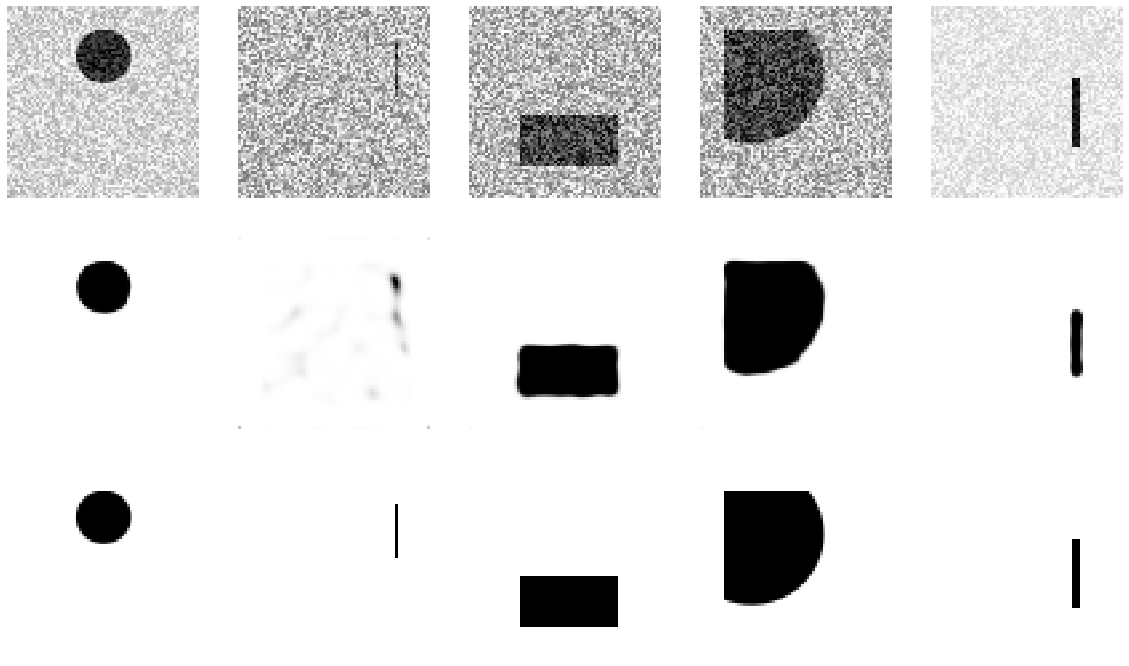

In [240]:
def show_images(row1, row2, row3):
    plt.figure(figsize=(20, 12))
    for i in range(5):
        # before
        plt.subplot(3, 5, i+1)
        plt.imshow(row1[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(3, 5, 5+i+1)
        plt.imshow(row2[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(3, 5, 10+i+1)
        plt.imshow(row3[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

X_test_denoised = model.predict(X_test_noisy)

show_images(X_test_noisy, X_test_denoised, X_test)